Data Processing

In [2]:
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, Subset, ConcatDataset
from pathlib import Path
import numpy as np
from tqdm import tqdm
import abc
import wandb
from torchvision import transforms as T
# from byol_pytorch import BYOL
from scipy.spatial.transform import Rotation as R
from PIL import Image
import torchvision
import json
from torch.utils.data import DataLoader
import os
import pickle as pkl
import matplotlib.pyplot as plt
import math

# create abstract Dataset class called StickDataset
import cv2


from utils.r3D_semantic_dataset import load_depth
from utils.metrics import get_act_mean_std
from utils.traverse_data import iter_dir_for_traj_pths


class BaseStickDataset(Dataset, abc.ABC):
    def __init__(self, traj_path, time_skip, time_offset, time_trim):
        super().__init__()
        self.traj_path = Path(traj_path)
        self.time_skip = time_skip
        self.time_offset = time_offset
        self.time_trim = time_trim
        self.img_pth = self.traj_path / "images"
        self.depth_pth = self.traj_path / "depths"
        self.conf_pth = self.traj_path / "confs"
        self.labels_pth = self.traj_path / "labels.json"

        self.labels = json.load(self.labels_pth.open("r"))
        self.img_keys = sorted(self.labels.keys())
        # lable structure: {image_name: {'xyz' : [x,y,z], 'rpy' : [r, p, y], 'gripper': gripper}, ...}

        self.labels = np.array(
            [self.flatten_label(self.labels[k]) for k in self.img_keys]
        )

        # filter using time_skip and time_offset and time_trim. start from time_offset, skip time_skip, and remove last time_trim
        self.labels = self.labels[: -self.time_trim][self.time_offset :: self.time_skip]

        # filter keys using time_skip and time_offset and time_trim. start from time_offset, skip time_skip, and remove last time_trim
        self.img_keys = self.img_keys[: -self.time_trim][
            self.time_offset :: self.time_skip
        ]

    def flatten_label(self, label):
        # flatten label
        xyz = label["xyz"]
        rpy = label["rpy"]
        gripper = label["gripper"]
        return np.concatenate((xyz, rpy, np.array([gripper])))

    def __len__(self):
        return len(self.img_keys)

    def __getitem__(self, idx):
        # not implemented

        raise NotImplementedError


class StickDataset(BaseStickDataset, abc.ABC):
    def __init__(
        self, traj_path, traj_len, time_skip, time_offset, time_trim, traj_skip
    ):
        super().__init__(traj_path, time_skip, time_offset, time_trim)
        self.traj_len = traj_len
        self.traj_skip = traj_skip
        self.reformat_labels(self.labels)
        self.act_metrics = None

    def set_act_metrics(self, act_metrics):
        self.act_metrics = act_metrics

    def reformat_labels(self, labels):
        # reformat labels to be delta xyz, delta rpy, next gripper state
        new_labels = np.zeros_like(labels)
        new_img_keys = []

        for i in range(len(labels) - 1):
            if i == 0:
                current_label = labels[i]
                next_label = labels[i + 1]
            else:
                next_label = labels[i + 1]

            current_matrix = np.eye(4)
            r = R.from_euler("xyz", current_label[3:6], degrees=False)
            current_matrix[:3, :3] = r.as_matrix()
            current_matrix[:3, 3] = current_label[:3]

            next_matrix = np.eye(4)
            r = R.from_euler("xyz", next_label[3:6], degrees=False)
            next_matrix[:3, :3] = r.as_matrix()
            next_matrix[:3, 3] = next_label[:3]

            delta_matrix = np.linalg.inv(current_matrix) @ next_matrix
            delta_xyz = delta_matrix[:3, 3]
            delta_r = R.from_matrix(delta_matrix[:3, :3])
            delta_rpy = delta_r.as_euler("xyz", degrees=False)

            del_gripper = next_label[6] - current_label[6]
            xyz_norm = np.linalg.norm(delta_xyz)
            rpy_norm = np.linalg.norm(delta_r.as_rotvec())

            if xyz_norm < 0.01 and rpy_norm < 0.008 and abs(del_gripper) < 0.05:
                # drop this label and corresponding image_key since the delta is too small (basically the same image)
                continue

            new_labels[i] = np.concatenate(
                (delta_xyz, delta_rpy, np.array([next_label[6]]))
            )
            new_img_keys.append(self.img_keys[i])
            current_label = next_label

        # remove labels with all 0s
        new_labels = new_labels[new_labels.sum(axis=1) != 0]
        assert len(new_labels) == len(new_img_keys)
        self.labels = new_labels
        self.img_keys = new_img_keys

    def load_labels(self, idx):
        # load labels with window size of traj_len, starting from idx and moving window by traj_skip
        labels = self.labels[
            idx * self.traj_skip : idx * self.traj_skip + self.traj_len
        ]
        # normalize labels
        if self.act_metrics is not None:
            labels = (labels - self.act_metrics["mean"].numpy()) / self.act_metrics[
                "std"
            ].numpy()
        return labels

    def get_img_pths(self, idx):
        # get image paths with window size of traj_len, starting from idx and moving window by traj_skip
        img_keys = self.img_keys[
            idx * self.traj_skip : idx * self.traj_skip + self.traj_len
        ]
        img_pths = [self.img_pth / k for k in img_keys]
        return img_pths

    def __len__(self):
        return (len(self.img_keys) - self.traj_len) // self.traj_skip + 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError()
        return None, self.load_labels(idx)


class ImageStickDataset(StickDataset):
    def __init__(
        self,
        traj_path,
        traj_len,
        time_skip,
        time_offset,
        time_trim,
        traj_skip,
        img_size,
        pre_load=False,
        transforms=None,
    ):
        super().__init__(
            traj_path, traj_len, time_skip, time_offset, time_trim, traj_skip
        )
        self.img_size = img_size
        self.pre_load = pre_load
        self.transforms = transforms
        self.preprocess_img_transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(self.img_size),
                torchvision.transforms.ToTensor(),
            ]
        )
        if self.pre_load:
            self.imgs = self.load_imgs()

    def load_imgs(self):
        # load images in uint8 with window size of traj_len, starting from idx and moving window by traj_skip
        imgs = []

        for key in tqdm(self.img_keys):
            img = Image.open(str(self.img_pth / key))
            img = self.preprocess_img_transforms(img)
            imgs.append(img)
        # add a nex axis at the beginning
        imgs = torch.stack(imgs, dim=0)
        return imgs

    def __getitem__(self, idx):
        _, labels = super().__getitem__(idx)

        if self.pre_load:
            imgs = self.imgs[
                idx * self.traj_skip : idx * self.traj_skip + self.traj_len
            ]
        else:
            imgs = []
            for key in self.img_keys[
                idx * self.traj_skip : idx * self.traj_skip + self.traj_len
            ]:
                img = Image.open(str(self.img_pth / key))
                img = self.preprocess_img_transforms(img)
                imgs.append(img)
            # add a nex axis at the beginning
            imgs = torch.stack(imgs, dim=0)

        if self.transforms:
            imgs = self.transforms(imgs)

        return imgs, labels


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def get_image_stick_dataset(
    data_path,
    traj_len=1,
    traj_skip=1,
    time_skip=4,
    time_offset=5,
    time_trim=5,
    img_size=224,
    pre_load=True,
    apply_transforms=True,
    val_mask=None,
    mask_texts=None,
    cfg=None,
):
    # add transforms for normalization and converting to float tensor
    if type(data_path) == str:
        data_path = Path(data_path)

    if apply_transforms:
        transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                )
            ]
        )
    else:
        transforms = None

    train_traj_paths, val_traj_paths, test_traj_paths = iter_dir_for_traj_pths(
        data_path, val_mask, mask_texts
    )
    # train_traj_paths = train_traj_paths[:64]
    # val_traj_paths = val_traj_paths[:16]
    # test_traj_paths = test_traj_paths[:16]
    # concatenate all the Datasets for all the trajectories
    train_dataset = ConcatDataset(
        [
            ImageStickDataset(
                traj_path,
                traj_len,
                time_skip,
                time_offset_n,
                time_trim,
                traj_skip,
                img_size,
                pre_load=pre_load,
                transforms=transforms,
            )
            for traj_path, time_offset_n in itertools.product(
                train_traj_paths, [time_offset, time_offset + 2]
            )
        ]
    )

    

    if len(val_traj_paths) > 0:
        val_dataset = ConcatDataset(
            [
                ImageStickDataset(
                    traj_path,
                    traj_len,
                    time_skip,
                    time_offset,
                    time_trim,
                    traj_skip,
                    img_size,
                    pre_load=pre_load,
                    transforms=transforms,
                )
                for traj_path in val_traj_paths
            ]
        )
        
    else:
        val_dataset = None

    if len(test_traj_paths) > 0:
        test_dataset = ConcatDataset(
            [
                ImageStickDataset(
                    traj_path,
                    traj_len,
                    time_skip,
                    time_offset,
                    time_trim,
                    traj_skip,
                    img_size,
                    pre_load=pre_load,
                    transforms=transforms,
                )
                for traj_path in test_traj_paths
            ]
        )
    else:
        test_dataset = None

    return train_dataset, val_dataset, test_dataset

In [4]:
val_mask = {'home': [],
  'env': [],
  # 'traj': ['2023-07-11--15-16-54_0', '2023-07-11--15-18-02_0',  '2023-07-11--15-19-10_0',  '2023-07-11--15-20-19_0',  '2023-07-11--15-21-14_0', '2023-07-11--15-17-36_0',  '2023-07-11--15-18-35_0',  '2023-07-11--15-19-42_0']}
  'traj': ['2023-07-11--15-16-54_0']}

apply_transforms = True  ## We apply transforms now for normalizing the image
img_size = [224, 224]

In [5]:
train, val, test = get_image_stick_dataset(data_path='/home/robot-lab/data/Data/MicroOpener', img_size=img_size, val_mask = val_mask, apply_transforms = apply_transforms)

Iterating through:  /home/robot-lab/data/Data/MicroOpener
Iterating through:  /home/robot-lab/data/Data/MicroOpener/Courant
Iterating through:  /home/robot-lab/data/Data/MicroOpener/Courant/Env1
Total number of trajectories:  8
total number of train trajectories:  8
total number of test trajectories:  0
Total number of val trajectories:  1


 18%|█▊        | 14/79 [00:00<00:00, 138.03it/s]

100%|██████████| 92/92 [00:00<00:00, 155.99it/s]


In [ ]:
def normalize_labels(dataset):
    # Extract the labels from the dataset
    labels = [data[1] for data in dataset]

    # Convert labels to numpy array for easier calculations
    labels_array = np.array(labels)
    labels_array = labels_array.reshape(-1, 7)
    # Calculate the mean and standard deviation of the labels
    mean = np.mean(labels_array, axis=0)
    std_dev = np.std(labels_array, axis=0)
    labels_array = (labels_array - mean) / std_dev
    # Normalize the labels
    normalized_labels = [(dataset[i][0], labels_array[i]) for i in range(len(dataset))]

    return normalized_labels, mean, std_dev
train, mean, std = normalize_labels(train)
print(mean) #val_mean = [-1.65969211e-03, 1.78176055e-03, 4.28184121e-04, 1.06313849e-03, -1.69119069e-03, 1.82573215e-05, 6.80866514e-01]
print(std) #val_std = [0.00826402, 0.01361875, 0.00387819, 0.00611709, 0.01721554, 0.00971739, 0.39525879]
#train_mean = [-1.84680528e-03, 1.88239165e-03, 6.56352240e-04, 6.61310625e-05, -5.19523775e-04, 4.96648311e-04, 7.79042174e-01]
#train_std = [0.00833277, 0.01495058, 0.00507645, 0.00762441, 0.01684678, 0.0103782, 0.36494638]

[-1.84680528e-03  1.88239165e-03  6.56352240e-04  6.61310625e-05
 -5.19523775e-04  4.96648311e-04  7.79042174e-01]
[0.00833277 0.01495058 0.00507645 0.00762441 0.01684678 0.0103782
 0.36494638]


In [ ]:
len(train)

1609

(1609, 7)


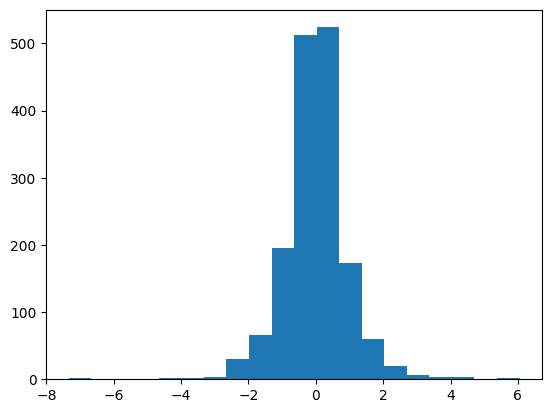

In [ ]:
labels = [data[1] for data in train]
labels_array = np.array(labels)
labels_array = labels_array.reshape(-1, 7)
print(labels_array.shape)
normalizer = NormalizeActions()
denormalizer = deNormalizeActions()
norm_labels = normalizer(torch.tensor(labels_array).to('cuda')).cpu().numpy()
plt.hist(norm_labels[:, 4], bins=20)
plt.show()

visualize reconstruction

In [69]:
original = train[592][0]
originalgpu = original.to('cuda')
logitsa = bvae.encoder(originalgpu)[:, :7]
print(logitsa)

tensor([[ 0.0024,  0.0163, -0.0055, -0.0157,  0.0083, -0.0040,  0.9780]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [91]:
original = train[155][0]
originalgpu = original.to('cuda')
logitsb = bvae.encoder(originalgpu)[:, :7]
print(logitsb)

tensor([[-0.0081, -0.0062,  0.0024,  0.0079, -0.0148,  0.0012,  1.0719]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [116]:
original = train[592][0].to('cuda')

In [ ]:
592, 132, 428, 976, 
592, 132, 428

In [114]:
sample1 = train[592][0].to('cuda')
sample2 = train[132][0].to('cuda')
sample3 = train[428][0].to('cuda')
logits1 = bvae(sample1, 1, return_logits_i=True)
logits2 = bvae(sample2, 1, return_logits_i=True)
logits3 = bvae(sample3, 1, return_logits_i=True)
print(logits1, "\n", logits2, "\n", logits3)

tensor([[ 0.0037,  0.0166, -0.0088, -0.0150,  0.0074, -0.0039,  0.9785]],
       device='cuda:0', grad_fn=<AddBackward0>) 
 tensor([[-0.0064,  0.0122,  0.0017, -0.0087, -0.0033,  0.0096,  0.9862]],
       device='cuda:0', grad_fn=<AddBackward0>) 
 tensor([[-2.4718e-03, -1.4603e-02, -4.1699e-03, -2.4400e-04, -1.3934e-03,
         -9.3037e-04,  9.2223e-01]], device='cuda:0', grad_fn=<AddBackward0>)


In [107]:
reconstruction = bvae(original, 1, return_recon_i=True)

In [131]:
logits = torch.tensor([[ 0.0037,  0.0166, -0.0088, -0.0150,  0.0074, -0.0039,  0.9785]], device='cuda:0')

In [133]:
reconstruction = bvae.decoder(logits)[:, :3]
reconstruction.shape

torch.Size([1, 3, 224, 224])

In [134]:
reconstruction = reconstruction - torch.min(reconstruction)
reconstruction = reconstruction/torch.max(reconstruction)
reconstruction = reconstruction.detach().cpu().numpy()
reconstruction = reconstruction.reshape(3, 224, 224)
reconstruction = np.transpose(reconstruction, (1, 2, 0))
print(reconstruction.shape)

(224, 224, 3)


In [120]:
original = original[0].reshape(224, 224, 3)
original = original[:85, :85, :]
original = original.cpu().numpy()
original = original-np.min(original)
original = np.round(original/np.max(original)*255)
#convert dtype to int
original = original.astype(np.uint8)


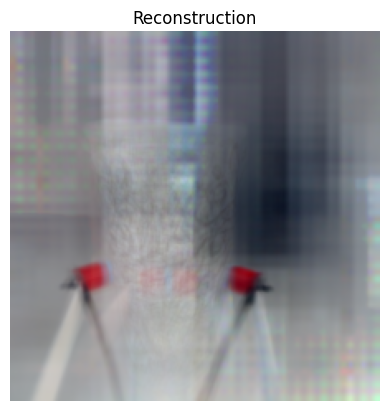

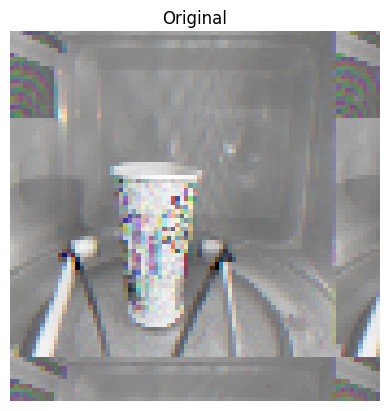

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random pixel values between 0 and 255
# pixels = np.random.randint(0, 256, size=(28, 28), dtype=np.uint8)

# Plotting

plt.imshow(reconstruction)  # Display the image
plt.axis('off')                  # Turn off axis labels
plt.title('Reconstruction')
plt.show() 
plt.imshow(original)  # Display the image
plt.axis('off')                  # Turn off axis labels
plt.title('Original')       # Title of the plot
plt.show()                        # Display the plot

#convert to numpy array

#get max value of np array
    

In [6]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [7]:
images = [data[0] for data in train]
#convert from shape [{image}, {image}, ...] to torch tensor of shape [num_images, 3, 224, 224]
images = torch.cat([image[0] for image in train], dim=0).to('cuda')
#get mean rgb values
image_means = torch.mean(images, dim=0)
image_stds = torch.std(images, dim=0)

In [8]:
#create a class to normalize the labels given a list of means and stds for each of the 7 values in the labels
class NormalizeActions(nn.Module):
    def __init__(self):
        super(NormalizeActions, self).__init__()
        self.means = [-1.84680528e-03, 1.88239165e-03, 6.56352240e-04, 6.61310625e-05, -5.19523775e-04, 4.96648311e-04, 7.79042174e-01]
        self.stds = [0.00833277, 0.01495058, 0.00507645, 0.00762441, 0.01684678, 0.0103782, 0.36494638]
        #convert to tensor
        self.means = torch.tensor(self.means).to('cuda')
        self.stds = torch.tensor(self.stds).to('cuda')

    def __call__(self, sample):
        sample = (sample - self.means) / self.stds
        return sample
#create a class to denormalize the labels given a list of means and stds for each of the 7 values in the labels
class deNormalizeActions(nn.Module):
    def __init__(self):
        super(deNormalizeActions, self).__init__()
        self.means = [-1.84680528e-03, 1.88239165e-03, 6.56352240e-04, 6.61310625e-05, -5.19523775e-04, 4.96648311e-04, 7.79042174e-01]
        self.stds = [0.00833277, 0.01495058, 0.00507645, 0.00762441, 0.01684678, 0.0103782, 0.36494638]
        #convert to tensor
        self.means = torch.tensor(self.means).to('cuda')
        self.stds = torch.tensor(self.stds).to('cuda')
    def __call__(self, sample):
        sample_means = sample[:, :7]
        sample_stds = sample[:, 7:]
        # print("sample shape: ", sample_means.shape, "sample type: ", sample_means.dtype, "means shape: ", self.means.shape, "means type: ", self.means.dtype)
        sample_means = (sample_means * self.stds) + self.means
        #return sample in its original form by concatenating the means and stds
        return torch.cat((sample_means, sample_stds), 1)
#normalize images
class NormalizeImages(nn.Module):
    def __init__(self):
        super(NormalizeImages, self).__init__()
        #get all images from train dataset
        self.means = image_means
        self.stds = image_stds

    def __call__(self, sample):
        sample = (sample - self.means) / self.stds
        return sample
#denormalize images
class deNormalizeImages(nn.Module):
    def __init__(self):
        super(deNormalizeImages, self).__init__()
        #get all images from train dataset
        self.means = image_means
        self.stds = image_stds

    def __call__(self, sample):
        sample_means= sample[:, :3]
        sample_stds = sample[:, 3:]
        sample_means = (sample_means * self.stds) + self.means
        return torch.cat((sample_means, sample_stds), 1)

Bidirectional VAE

In [136]:
class BVAE(nn.Module):
    def __init__(
        self,
        image_size=224,
        hidden_dim=7,
        mid_dim = 28,
        channels=3,
        num_filters=48,
        smooth_l1_loss=False,
        kl_div_loss_weight=0.,
        normalization=((*((0.5,) * 3), 0), (*((0.5,) * 3), 1))
    ):
        super().__init__()
        # assert math.log2(image_size).is_integer(), 'image size must be a power of 2'
        self.channels = channels
        self.image_size = image_size
        self.hidden_dim = hidden_dim
        self.mid_dim = mid_dim
        self.num_filters = num_filters

        enc_spatial_dim = 2
        enc_out_dim = num_filters * enc_spatial_dim * enc_spatial_dim #48*2*2=192
        enc_chans = [
            channels,
            num_filters//4,
            num_filters//2,
            num_filters,
        ]
        dec_chans = enc_chans[::-1]
        # Encoder layers
        self.encoder = nn.Sequential(

            NormalizeImages(),

            nn.Conv2d(enc_chans[0], enc_chans[1], 2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(enc_chans[1]),
            nn.LeakyReLU(0.2),

            nn.Conv2d(enc_chans[1], enc_chans[1], 2, stride=2, padding=0),

            nn.Conv2d(enc_chans[1], enc_chans[2], 2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(enc_chans[2]),
            nn.LeakyReLU(0.2),

            nn.Conv2d(enc_chans[2], enc_chans[3], 2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(enc_chans[3]),
            nn.LeakyReLU(0.2),


            nn.Flatten(),
            nn.Linear(enc_out_dim, mid_dim), nn.ReLU(),
            nn.Linear(mid_dim, 2*hidden_dim), #NO RELU!!!

            deNormalizeActions()
        
        )
        #Decoder layers
        self.decoder = nn.Sequential(

            NormalizeActions(),

            nn.Linear(hidden_dim, mid_dim), nn.ReLU(),
            nn.Linear(mid_dim, enc_out_dim), nn.LeakyReLU(),
            Reshape((-1, num_filters, enc_spatial_dim, enc_spatial_dim)), #[101, 48, 2, 2]

            nn.ConvTranspose2d(dec_chans[0], dec_chans[1], 2, stride=2, padding=0), #[101, 24, 8, 8]
            nn.Upsample(scale_factor=2, mode='bilinear'), #[101, 48, 4, 4]
            nn.BatchNorm2d(dec_chans[1]),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(dec_chans[1], dec_chans[2], 2, stride=2, padding=0), #[101, 12, 28, 28]
            nn.Upsample(scale_factor=14/8, mode='bilinear'), #[101, 24, 14, 14]
            nn.BatchNorm2d(dec_chans[2]),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(dec_chans[2], dec_chans[3]*2, 2, stride=2, padding=0), #[101, 6, 224, 224]
            nn.Upsample(scale_factor=4, mode='bilinear'), #[101, 12, 112, 112]
            nn.BatchNorm2d(dec_chans[3]*2),
            nn.LeakyReLU(0.2),
            
            deNormalizeImages()
        )
        self.translator = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim)
        )
        # Calculate the spatial dimensions after encoder layers
        
        
        

        self.loss_fn = F.smooth_l1_loss if smooth_l1_loss else F.mse_loss
        

    def encode(self, img):
        enc_out = self.encoder(img)
        return enc_out

    def decode(self, latent_sample):
        out = self.decoder(latent_sample)
        return out

    def image_reparameterize(self, enc_out, std_constant=0.5):
        mean = enc_out[:, :self.hidden_dim]  # shape: [batch_size]
        std = enc_out[:, self.hidden_dim:]  # shape: [batch_size]
        # std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return (mean + eps*std*std_constant), mean, std

    def action_reparameterize(self, dec_out, std_constant=0.5):
        mean = dec_out[:, :self.channels]
        std = dec_out[:, self.channels:]
        # std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return (mean + eps*std*std_constant), mean, std

    def load_model(self, path):
        self.encoder.load_state_dict(torch.load(path+"_enc.pth"))
        self.decoder.load_state_dict(torch.load(path+"_dec.pth"))
    def save_model(self, path):
        torch.save(self.encoder.state_dict(), path+"_enc.pth")
        torch.save(self.decoder.state_dict(), path+"_dec.pth")
    def forward(self, img, act, return_recon_i=False, return_logits_i=False):
        normalize_image = NormalizeImages()
        denormalize_image = deNormalizeImages()
        normalize_action = NormalizeActions()
        denormalize_action = deNormalizeActions()
        if (not return_recon_i) and (not return_logits_i):
            
            dec_out = self.decode(act)
            latent_sample_a, latent_mean_a, latent_std = self.action_reparameterize(dec_out)
            reconstructed_act = self.encode(latent_sample_a)
            reconstructed_act, w, q = self.image_reparameterize(reconstructed_act)
            recon_loss_a = self.loss_fn(normalize_action(act), normalize_action(reconstructed_act))
            # KL divergence
            latent_logvar = 2 * torch.log(latent_std + 1e-8)  # Adding a small epsilon (1e-8) for numerical stability
            kl_div_a = -0.5 * torch.sum(1 + latent_logvar - latent_mean_a.pow(2) - latent_logvar.exp())

        
        enc_out = self.encode(img)
        latent_sample_i, latent_mean_i, latent_std = self.image_reparameterize(enc_out)
        if return_logits_i:
            return latent_sample_i
        reconstructed_img = self.decode(latent_sample_i)
        reconstructed_img, w, q = self.action_reparameterize(reconstructed_img)
        if return_recon_i:
            return reconstructed_img

        # # Reconstruction loss
        recon_loss_i = self.loss_fn(normalize_image(img), normalize_image(reconstructed_img))
        
        # # KL divergence
        # # print(latent_mean.shape, latent_std.shape)
        latent_logvar = 2 * torch.log(latent_std + 1e-8)  # Adding a small epsilon (1e-8) for numerical stability
        # # print(latent_logvar.shape)
        kl_div_i = -0.5 * torch.sum(1 + latent_logvar - latent_mean_i.pow(2) - latent_logvar.exp())
        # print(kl_div_i.shape)
        #Supervised loss
        # latent_mean_i = self.translator(latent_mean_i)
        i_supervised_loss = F.mse_loss(normalize_action(latent_mean_i), normalize_action(act))
        # i_supervised_loss = F.mse_loss(latent_mean_i, act)
        a_supervised_loss = F.mse_loss(normalize_image(latent_mean_a), normalize_image(img))
        
        # loss = recon_loss_i #+a_supervised_loss

        return i_supervised_loss, recon_loss_i, recon_loss_a, kl_div_i, kl_div_a, latent_sample_i, latent_sample_a, a_supervised_loss

In [137]:
bs = 128
bvae = BVAE()
enc_optimizer = torch.optim.Adam(bvae.encoder.parameters(), lr=3e-3)
dec_optimizer = torch.optim.Adam(bvae.decoder.parameters(), lr=3e-3)
optimizer = torch.optim.Adam(bvae.parameters(), lr=3e-3)
train_loader = DataLoader(train, batch_size=bs, shuffle=True)
bvae=bvae.to('cuda')

In [30]:
val_loader = DataLoader(val, batch_size = 1, shuffle = True)

In [11]:
bvae.load_model('goodmodel')

In [138]:
run = wandb.init(project='BVAE')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: paul-nieuwerburgh. Use `wandb login --relogin` to force relogin


In [146]:
run.finish()

Action Reconstruction Loss,█▄▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Action Supervised Loss,▆▆█▆▆▅▆▆▆▄▃▅▄▅▅▆▄▄▅▃▄▃▃▄▆▃▃▃▃▃▃▂▃▂▃▁▂▁▂▂
Image Reconstruction Loss,▆▆█▆▅▅▅▅▅▃▃▄▄▄▄▆▄▄▅▃▃▃▃▃▄▂▃▂▂▂▂▁▂▂▂▁▁▁▂▂
Image Supervised Loss,█▆▆▇▃▃▄▄▃▃▂▄▂▂▂▃▃▂▂▂▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
Total Loss,█▅▆▅▄▄▄▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁
Action KL Loss,nan
Action Reconstruction Loss,0.04184
Action Supervised Loss,0.51114
Image KL Loss,nan
Image Reconstruction Loss,0.4631
Image Supervised Loss,0.06486


In [144]:
bvae=bvae.to('cuda')
mode = 0
dataset = ""
epochs = 1000
for epoch in range(epochs):
    for batch_idx, (image, action) in enumerate(train_loader):
        action = action.type(torch.float32)
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        optimizer.zero_grad()

        image = image.to('cuda')
        action = action.to('cuda')

        batch_size = image.shape[0]

        image = image.reshape(batch_size, 3, 224, 224)
        action = action.reshape(batch_size, 7)

        i_supervised_loss, i_recon_loss, a_recon_loss, i_kl_loss, a_kl_loss, i_latent, a_latent, a_supervised_loss = bvae.forward(image, action)
        
        enc_loss = i_supervised_loss
        dec_loss  = i_recon_loss
        loss = i_supervised_loss*1 + i_recon_loss*1 + a_recon_loss*1 + a_supervised_loss*1
        # enc_loss.backward(retain_graph=True)
        # dec_loss.backward()
        loss.backward()

        # enc_optimizer.step()
        # dec_optimizer.step()
        optimizer.step()
    print("epoch:", epoch+1, "loss:", enc_loss, i_recon_loss, i_kl_loss, i_supervised_loss, a_recon_loss, a_kl_loss, a_supervised_loss)
    # print("epoch:", epoch+1, "loss:", i_supervised_loss)
    wandb.log({dataset+"Total Loss": (i_recon_loss+a_recon_loss+i_supervised_loss+a_supervised_loss)/4, dataset+"Image Reconstruction Loss": i_recon_loss, dataset+"Image KL Loss": i_kl_loss, dataset+"Image Supervised Loss": i_supervised_loss, dataset+"Action Reconstruction Loss": a_recon_loss, dataset+"Action KL Loss": a_kl_loss, dataset+"Action Supervised Loss": a_supervised_loss})
    # wandb.log({"Total Loss": loss, "Image Reconstruction Loss": i_recon_loss, "Image KL Loss": i_kl_loss, "Image Supervised Loss": i_supervised_loss})
    

epoch: 1 loss: tensor(0.1360, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.6012, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(nan, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.1360, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0484, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(nan, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.7001, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 2 loss: tensor(0.1484, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.5312, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(nan, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.1484, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0584, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(nan, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.5131, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch: 3 loss: tensor(0.1358, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.6184, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(nan, device='cud

KeyboardInterrupt: 

In [145]:
bvae.save_model("fullytrainedBVAEmodel")

In [22]:
sum(p.numel() for p in bvae.parameters() if p.requires_grad)

24520